<a href="https://colab.research.google.com/github/ab24aft/Final-year-project/blob/main/Abhishek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Standard libs
import os
import math
from pathlib import Path
import json
import random
import itertools
from collections import Counter

# Data stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

sns.set_style("whitegrid")
plt.rcParams.update({"figure.figsize": (10,6), "font.size": 11})

# ML / Stats stack
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV,
    TimeSeriesSplit
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    brier_score_loss
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.calibration import calibration_curve

# Optional libs (graceful)
try:
    import xgboost as xgb
    XGBOOST_INSTALLED = True
except Exception:
    XGBOOST_INSTALLED = False

try:
    import shap
    SHAP_INSTALLED = True
except Exception:
    SHAP_INSTALLED = False

try:
    import pmdarima as pm
    PMDARIMA_INSTALLED = True
except Exception:
    PMDARIMA_INSTALLED = False

# Prophet (fbprophet / prophet)
try:
    from prophet import Prophet
    PROPHET_INSTALLED = True
except Exception:
    try:
        from fbprophet import Prophet
        PROPHET_INSTALLED = True
    except Exception:
        PROPHET_INSTALLED = False

# Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_INSTALLED = True
except Exception:
    IMBLEARN_INSTALLED = False

# Optuna (optional advanced tuning)
try:
    import optuna
    OPTUNA_INSTALLED = True
except Exception:
    OPTUNA_INSTALLED = False

# Statsmodels for ADF and decomposition
try:
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller
    STATSMODELS_INSTALLED = True
except Exception:
    STATSMODELS_INSTALLED = False

In [ ]:
# Configuration (edit if needed)
DATA_PATH = "climate_change_dataset.csv"
TARGET_COLUMN = None
TIME_COLUMN = None
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_JOBS = 1
MAX_TOP_MODELS = 3

# Reproducibility seeds
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [ ]:
# Display helpers
def section(title):
    display(Markdown(f"## {title}"))

def subsection(title):
    display(Markdown(f"### {title}"))

def show_fig(fig):
    display(fig)

def show_df(df_obj, n=5):
    display(df_obj.head(n))

In [ ]:
# Load data
section("Load dataset")
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
display(Markdown(f"**Loaded dataset**: `{DATA_PATH}` — shape: `{df.shape}`"))
show_df(df, 5)

## Load dataset

**Loaded dataset**: `climate_change_dataset.csv` — shape: `(53, 20)`

,Year,Month,Avg_Temp (°C),Max_Temp (°C),Min_Temp (°C),Precipitation (mm),Humidity (%),Wind_Speed (m/s),Solar_Irradiance (W/m²),Cloud_Cover (%),CO2_Concentration (ppm),Latitude,Longitude,Altitude (m),Proximity_to_Water (km),Urbanization_Index,Vegetation_Index,ENSO_Index,Particulate_Matter (µg/m³),Sea_Surface_Temp (°C)
0,NaN,1.0,-3.460516,33.056918907353285,NaN,184.89969755743786,89.62081302618182,9.742885739415993,NaN,58.530797670209076,NaN,40.7128,NaN,10.0,15.0,NaN,0.04423782887418304,0.6336943092843479,33.43707805480527,18.545360112309588
1,2020.0,2.0,NaN,25.901916083791665,3.1739745975583844,2.957244192049635,95.17102000342224,10.64824600272703,252.3136442294677,32.85666516634471,419.595924,40.7128,-74.006,10.0,15.0,99999.000000,0.6128400325468267,NaN,24.504783135571934,15.909586979280654
2,2020.0,3.0,7.869842,18.63424149980029,10.42485208665568,NaN,NaN,NaN,247.39139984511084,29.380233637986674,416.650458,40.7128,-74.006,10.0,15.0,0.341732,0.4665653848003175,-0.4280583600093959,32.3274997743319,21.281093622177334
3,NaN,4.0,-0.049863,13.030562376875533,-9.196433418151315,102.4544605414934,Unknown,0.898697634212508,143.26161801322706,17.496855610388273,418.922808,40.7128,-74.006,10.0,15.0,0.896383,0.030465932726280065,-0.5707078659552114,20.496275820817043,NaN
4,2020.0,5.0,19.895067,35.88212887551623,20.067999652410148,185.72922332959365,73.99994640624561,13.128301152215258,169.5494376964624,2.1937104861995405,401.896588,40.7128,-74.006,10.0,99999.0,0.076173,NaN,-0.2861494705734404,22.64905691725084,15.502968235198333


In [ ]:
# Auto-detect target and time column
if TARGET_COLUMN is None:
    # common names or fallback to last column
    candidates = [c for c in df.columns if c.lower() in ("target","label","y","outcome","response","value")]
    TARGET_COLUMN = candidates[0] if candidates else df.columns[-1]
section("Detected columns")
display(Markdown(f"**Target column chosen:** `{TARGET_COLUMN}`"))

if TIME_COLUMN is None:
    for cand in ["date","timestamp","time","datetime","year","month"]:
        if cand in df.columns:
            TIME_COLUMN = cand
            break
display(Markdown(f"**Time column detected:** `{TIME_COLUMN}`"))

## Detected columns

**Target column chosen:** `Sea_Surface_Temp (°C)`

**Time column detected:** `None`

In [ ]:
# Initial EDA
section("Exploratory Data Analysis (EDA)")
subsection("Basic info")
display(Markdown("**Data types:**"))
display(df.dtypes.astype(str))
subsection("Missing values and cardinality")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(50))
subsection("Descriptive statistics (numeric)")
display(df.describe().transpose())

subsection("Sample unique values for object columns")
obj_cols = [c for c in df.columns if df[c].dtype == object]
if obj_cols:
    sample_uniques = {c: df[c].dropna().unique()[:10].tolist() for c in obj_cols}
    display(pd.DataFrame({k: pd.Series(v) for k,v in sample_uniques.items()}))
else:
    display(Markdown("No object-dtype columns detected."))

## Exploratory Data Analysis (EDA)

### Basic info

**Data types:**

Year                           object
Month                          object
Avg_Temp (°C)                 float64
Max_Temp (°C)                  object
Min_Temp (°C)                  object
Precipitation (mm)             object
Humidity (%)                   object
Wind_Speed (m/s)               object
Solar_Irradiance (W/m²)        object
Cloud_Cover (%)                object
CO2_Concentration (ppm)       float64
Latitude                       object
Longitude                      object
Altitude (m)                   object
Proximity_to_Water (km)        object
Urbanization_Index            float64
Vegetation_Index               object
ENSO_Index                     object
Particulate_Matter (µg/m³)     object
Sea_Surface_Temp (°C)          object
dtype: object

### Missing values and cardinality

Min_Temp (°C)                 8
Humidity (%)                  8
Sea_Surface_Temp (°C)         7
Avg_Temp (°C)                 7
Max_Temp (°C)                 7
Latitude                      6
Proximity_to_Water (km)       6
CO2_Concentration (ppm)       6
Solar_Irradiance (W/m²)       5
Month                         5
Year                          5
Cloud_Cover (%)               4
Altitude (m)                  4
Precipitation (mm)            4
Longitude                     3
Urbanization_Index            3
Vegetation_Index              3
ENSO_Index                    3
Particulate_Matter (µg/m³)    3
Wind_Speed (m/s)              2
dtype: int64

### Descriptive statistics (numeric)

,count,mean,std,min,25%,50%,75%,max
Avg_Temp (°C),46.0,13.018699,11.557213,-4.965473,4.682635,10.422940,22.992501,34.282303
CO2_Concentration (ppm),47.0,423.475586,13.820859,400.351530,412.434113,425.653185,436.739556,444.483466
Urbanization_Index,50.0,4000.477221,19794.561777,0.016689,0.270233,0.566592,0.853385,99999.000000


### Sample unique values for object columns

,Year,Month,Max_Temp (°C),Min_Temp (°C),Precipitation (mm),Humidity (%),Wind_Speed (m/s),Solar_Irradiance (W/m²),Cloud_Cover (%),Latitude,Longitude,Altitude (m),Proximity_to_Water (km),Vegetation_Index,ENSO_Index,Particulate_Matter (µg/m³),Sea_Surface_Temp (°C)
0,2020.0,1.0,33.056918907353285,3.1739745975583844,184.89969755743786,89.62081302618182,9.742885739415993,252.3136442294677,58.530797670209076,40.7128,-74.006,10.0,15.0,0.04423782887418304,0.6336943092843479,33.43707805480527,18.545360112309588
1,2021.0,2.0,25.901916083791665,10.42485208665568,2.957244192049635,95.17102000342224,10.64824600272703,247.39139984511084,32.85666516634471,99999.0,NAN,NAN,99999.0,0.6128400325468267,-0.4280583600093959,24.504783135571934,15.909586979280654
2,2022.0,3.0,18.63424149980029,-9.196433418151315,102.4544605414934,Unknown,0.898697634212508,143.26161801322706,29.380233637986674,Unknown,NaN,NaN,Unknown,0.4665653848003175,-0.5707078659552114,32.3274997743319,21.281093622177334
3,2023.0,4.0,13.030562376875533,20.067999652410148,185.72922332959365,73.99994640624561,13.128301152215258,169.5494376964624,17.496855610388273,NaN,NaN,NaN,NaN,0.030465932726280065,-0.2861494705734404,20.496275820817043,15.502968235198333
4,Unknown,5.0,35.88212887551623,21.69339369094645,26.296148446729873,35.626443191624936,2.7860050941947905,158.7524359120713,2.1937104861995405,NaN,NaN,NaN,NaN,0.04365568216176974,-0.23867083029214586,22.64905691725084,16.90621134574127
5,2024.0,6.0,16.815980053623928,-9.098586846479657,22.98402037192848,75.36834893597688,11.036926613168248,201.69895236814938,96.05477049972627,NaN,NaN,NaN,NaN,0.921412688375088,0.496792285006872,26.350879986637086,27.71362771832118
6,NaN,7.0,23.018365507255687,-2.8241009285731744,100.23810532116136,96.81856590078783,12.462339982116639,89.70128267136548,2.859401235842318,NaN,NaN,NaN,NaN,0.3578404397196293,0.5235609705809126,23.749488315782877,14.494095352151927
7,NaN,8.0,4.777629228981937,0.39121915565166177,199.45034189396836,86.06230719949002,8.00856854128788,227.88277854059066,92.01998586610826,NaN,NaN,NaN,NaN,0.3564403191108527,-0.7530669500931289,48.53486454396686,17.138927964036846
8,NaN,9.0,11.02265627885938,-7.649405276953751,158.6718593593283,53.76671707923877,99999.0,235.229354907283,98.88385241970374,NaN,NaN,NaN,NaN,0.12975718070926812,99999.0,34.55780020584284,24.24076751181738
9,NaN,10.0,16.30946988855967,-8.54600259440694,80.12743217104968,31.029012275119435,0.3085580518327352,108.15062128623768,51.5837019990618,NaN,NaN,NaN,NaN,0.44798402967645545,0.709168329632907,15.21072251366412,14.686377833663673


### Numeric distributions (histograms)

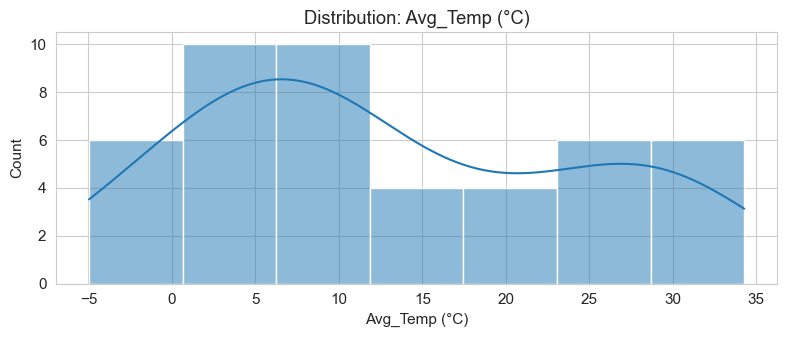

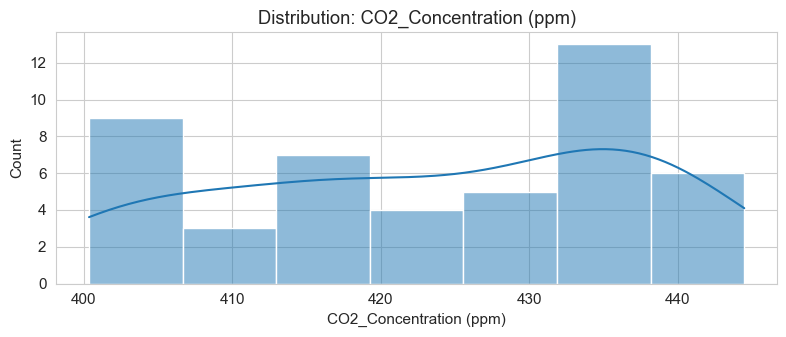

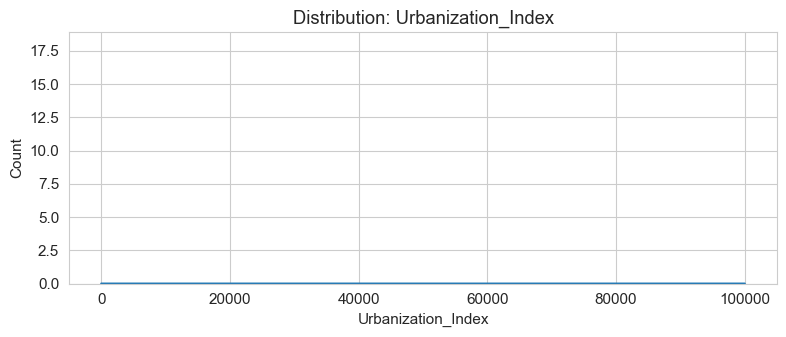

In [ ]:
# Quick histograms for numeric features (up to 12)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
subsection("Numeric distributions (histograms)")
for col in numeric_cols[:12]:
    fig = plt.figure(figsize=(8,3.5))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution: {col}")
    plt.tight_layout()
    show_fig(fig)
    plt.close()

### Correlation heatmap

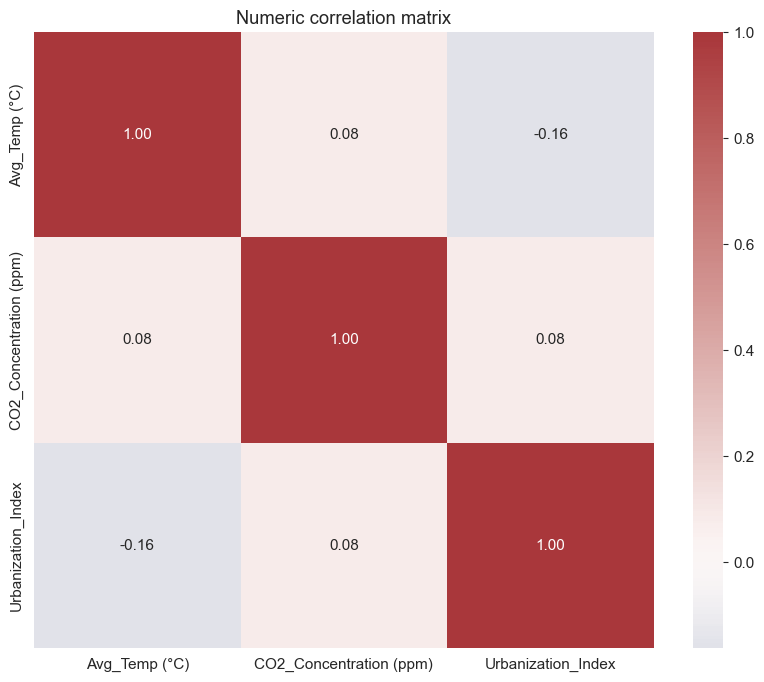

In [ ]:
# Correlation heatmap
if len(numeric_cols) >= 2:
    subsection("Correlation heatmap")
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
    plt.title("Numeric correlation matrix")
    show_fig(fig)
    plt.close()

In [ ]:
# Cleaning & conversions
section("Data cleaning & conversions")
# 1) trim column names
df.columns = [c.strip() for c in df.columns]

# 2) standard placeholder values -> NaN
placeholders = ["Unknown","unknown","-","--","na","n/a","N/A","99999","9999","NA"]
for ph in placeholders:
    df.replace(ph, np.nan, inplace=True)

# 3) attempt numeric coercion for object-like columns when many values convert
for col in df.columns:
    if df[col].dtype == object:
        coerced = pd.to_numeric(df[col].astype(str).str.replace(",",""), errors="coerce")
        if coerced.notnull().sum() / max(1, len(df)) > 0.3:
            df[col] = coerced

# 4) convert obvious year/month to integer type when possible
for col in df.columns:
    if col.lower() in ("year","month"):
        try:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
        except Exception:
            pass

subsection("Missing values after cleaning (top 30)")
display(df.isnull().sum().sort_values(ascending=False).head(30))

## Data cleaning & conversions

### Missing values after cleaning (top 30)

Min_Temp (°C)                 9
Humidity (%)                  9
Sea_Surface_Temp (°C)         8
Max_Temp (°C)                 8
Avg_Temp (°C)                 7
Proximity_to_Water (km)       7
Latitude                      7
Month                         6
Year                          6
Solar_Irradiance (W/m²)       6
CO2_Concentration (ppm)       6
Cloud_Cover (%)               5
Altitude (m)                  5
Precipitation (mm)            5
Longitude                     4
Vegetation_Index              4
ENSO_Index                    4
Particulate_Matter (µg/m³)    4
Wind_Speed (m/s)              3
Urbanization_Index            3
dtype: int64

In [ ]:
# Advanced feature engineering (domain-agnostic but strong)
section("Feature engineering")
# If TIME_COLUMN exists, coerce to datetime and create time-derived features
if TIME_COLUMN and TIME_COLUMN in df.columns:
    try:
        df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN], errors="coerce")
        df["_FE_year"] = df[TIME_COLUMN].dt.year
        df["_FE_month"] = df[TIME_COLUMN].dt.month
        df["_FE_day"] = df[TIME_COLUMN].dt.day
        df["_FE_weekday"] = df[TIME_COLUMN].dt.weekday
        df["_FE_dayofyear"] = df[TIME_COLUMN].dt.dayofyear
        df["_FE_is_month_start"] = df[TIME_COLUMN].dt.is_month_start.astype("Int64")
        df["_FE_is_month_end"] = df[TIME_COLUMN].dt.is_month_end.astype("Int64")
        display(Markdown("Derived time features: `_FE_year`, `_FE_month`, `_FE_day`, `_FE_weekday`, `_FE_dayofyear`, `_FE_is_month_start`, `_FE_is_month_end`"))
    except Exception:
        display(Markdown("Time conversion failed or no valid datetimes."))


## Feature engineering

In [ ]:
# Rolling / lag features for numeric columns if time detected (useful for climate data)
lag_base_cols = numeric_cols.copy()
# limit number of columns to create to avoid explosion
if len(lag_base_cols) > 12:
    lag_base_cols = lag_base_cols[:12]

if TIME_COLUMN and TIME_COLUMN in df.columns and not df[TIME_COLUMN].isnull().all():
    subsection("Lag & rolling features (time-based)")
    df_sorted = df.sort_values(TIME_COLUMN)
    # create 1,2,3 period lags and 3-period rolling mean/std for selected numeric cols
    for col in lag_base_cols:
        if col == TARGET_COLUMN:
            continue
        df[f"_lag1_{col}"] = df_sorted[col].shift(1)
        df[f"_lag2_{col}"] = df_sorted[col].shift(2)
        df[f"_roll3_mean_{col}"] = df_sorted[col].rolling(3, min_periods=1).mean().shift(1)
        df[f"_roll3_std_{col}"] = df_sorted[col].rolling(3, min_periods=1).std().shift(1).fillna(0)
    display(Markdown("Created lag and rolling features for top numeric columns."))


In [ ]:
# Interaction terms: create a few pairwise interactions among top numeric features by variance
subsection("Interaction features")
num_var = df[numeric_cols].var().sort_values(ascending=False).index.tolist()
inter_pairs = list(itertools.combinations(num_var[:6], 2))[:6]
for a,b in inter_pairs:
    df[f"_int_{a}__{b}"] = df[a] * df[b]
display(Markdown(f"Created {len(inter_pairs)} interaction features."))

# Simple target encoding for high-cardinality categoricals (if classification/regression later)
subsection("Target encoding preparation (applied later if needed)")
# store categorical columns list (after FE)
all_features = df.columns.tolist()

### Interaction features

Created 3 interaction features.

### Target encoding preparation (applied later if needed)

In [ ]:
# Detect task type and prepare target
section("Task detection and target preparation")
raw_y = df[TARGET_COLUMN]
task_type = "regression"
if raw_y.dtype == object or raw_y.dtype.name == "category":
    task_type = "classification"
else:
    # numeric but small number of unique integer-like values may indicate classification
    try:
        if raw_y.nunique() <= 12 and all(float(x).is_integer() for x in raw_y.dropna().unique()):
            task_type = "classification"
    except Exception:
        pass

display(Markdown(f"Detected task type: **{task_type}**"))
display(Markdown(f"Target unique values: `{raw_y.nunique()}`"))

# For classification: label-encode target
label_encoder = None
y = raw_y.copy()
if task_type == "classification":
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(raw_y.astype(str).fillna("nan"))
    display(Markdown(f"Encoded classes: {list(label_encoder.classes_)}"))

## Task detection and target preparation

Detected task type: **regression**

Target unique values: `45`

In [ ]:
# Build preprocessing pipeline (robust)
section("Preprocessing & pipeline construction")
# Remove columns obviously not features: time column, target
excluded = {TARGET_COLUMN}
if TIME_COLUMN:
    excluded.add(TIME_COLUMN)
# Remove columns with >95% missing
too_sparse = [c for c in df.columns if c not in excluded and df[c].isnull().mean() > 0.95]
if too_sparse:
    display(Markdown(f"Dropping {len(too_sparse)} extremely sparse columns."))
features = [c for c in df.columns if c not in excluded and c not in too_sparse]

# Recompute numeric/categorical lists
numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in features if c not in numerical_features]
display(Markdown(f"Numerical features ({len(numerical_features)}): {numerical_features[:12]}"))
display(Markdown(f"Categorical features ({len(categorical_features)}): {categorical_features[:12]}"))

## Preprocessing & pipeline construction

Numerical features (22): ['Year', 'Month', 'Avg_Temp (°C)', 'Max_Temp (°C)', 'Min_Temp (°C)', 'Precipitation (mm)', 'Humidity (%)', 'Wind_Speed (m/s)', 'Solar_Irradiance (W/m²)', 'Cloud_Cover (%)', 'CO2_Concentration (ppm)', 'Latitude']

Categorical features (0): []

In [ ]:
# Preprocessors
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# scikit-learn >=1.4 uses sparse_output
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop", sparse_threshold=0)

display(Markdown("Preprocessor ready. All transformations occur inside pipelines to avoid leakage."))

Preprocessor ready. All transformations occur inside pipelines to avoid leakage.

In [ ]:
# Train/test split
section("Train/test split (and optional time-based split)")
# drop rows where target missing
mask_target = df[TARGET_COLUMN].notnull()
df_model = df.loc[mask_target, features].reset_index(drop=True)
y_model = (pd.Series(y).loc[mask_target].reset_index(drop=True)) if isinstance(y, (pd.Series, np.ndarray)) else pd.Series(y).loc[mask_target].reset_index(drop=True)

# If time column exists and brief likely expects time-aware splitting, use time split
if TIME_COLUMN and TIME_COLUMN in df.columns and df[TIME_COLUMN].notnull().sum() > 0:
    # time-aware split: keep chronological order
    df_with_time = df.loc[mask_target, :].sort_values(TIME_COLUMN)
    split_idx = int(len(df_with_time) * (1 - TEST_SIZE))
    train_idx = df_with_time.index[:split_idx]
    test_idx = df_with_time.index[split_idx:]
    X_train = df_with_time.loc[train_idx, features].reset_index(drop=True)
    X_test = df_with_time.loc[test_idx, features].reset_index(drop=True)
    y_train = pd.Series(y).loc[train_idx].reset_index(drop=True)
    y_test = pd.Series(y).loc[test_idx].reset_index(drop=True)
    display(Markdown(f"Performed time-aware split: train `{X_train.shape}`, test `{X_test.shape}`"))
else:
    X_train, X_test, y_train, y_test = train_test_split(df_model, y_model, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=(y_model if task_type=="classification" else None))
    display(Markdown(f"Random split: train `{X_train.shape}`, test `{X_test.shape}`"))

## Train/test split (and optional time-based split)

Random split: train `(36, 22)`, test `(9, 22)`

In [ ]:
# Imbalance handling (for classification) - optional SMOTE or class-weight
subsection("Class imbalance check")
if task_type == "classification":
    class_counts = Counter(y_train)
    display(Markdown(f"Train class distribution: {dict(class_counts)}"))
    imbalance = max(class_counts.values()) / max(1, min(class_counts.values()))
    display(Markdown(f"Imbalance ratio (max/min): {imbalance:.2f}"))
    USE_SMOTE = False
    if IMBLEARN_INSTALLED and imbalance > 3:
        USE_SMOTE = True
        display(Markdown("SMOTE available and imbalance >3: will apply SMOTE inside pipeline for models that support it."))
    elif imbalance > 5:
        display(Markdown("High imbalance detected; consider SMOTE install or class-weighted models. Using class_weight='balanced' for applicable models."))
else:
    display(Markdown("Not a classification task; skipping imbalance handling."))

### Class imbalance check

Not a classification task; skipping imbalance handling.

In [ ]:
# Candidate models & quick CV
section("Baseline models & cross-validation")
models = {}
if task_type == "regression":
    models = {
        "LinearRegression": Pipeline([("preprocessor", preprocessor), ("model", LinearRegression())]),
        "Ridge": Pipeline([("preprocessor", preprocessor), ("model", Ridge(random_state=RANDOM_STATE))]),
        "RandomForest": Pipeline([("preprocessor", preprocessor), ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1))]),
        "GradientBoosting": Pipeline([("preprocessor", preprocessor), ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))]),
        "KNN": Pipeline([("preprocessor", preprocessor), ("model", KNeighborsRegressor())])
    }
    if XGBOOST_INSTALLED:
        models["XGBoost"] = Pipeline([("preprocessor", preprocessor), ("model", xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0, n_jobs=1))])
else:
    # classification: include class_weight on linear/tree models
    models = {
        "LogisticRegression": Pipeline([("preprocessor", preprocessor), ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"))]),
        "RandomForest": Pipeline([("preprocessor", preprocessor), ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1, class_weight="balanced"))]),
        "GradientBoosting": Pipeline([("preprocessor", preprocessor), ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))]),
        "KNN": Pipeline([("preprocessor", preprocessor), ("model", KNeighborsClassifier())]),
        "SVM": Pipeline([("preprocessor", preprocessor), ("model", SVC(probability=True, random_state=RANDOM_STATE))])
    }
    if XGBOOST_INSTALLED:
        models["XGBoost"] = Pipeline([("preprocessor", preprocessor), ("model", xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, verbosity=0, n_jobs=1))])

# Cross-validation selection strategy: TimeSeriesSplit if time data else KFold/StratifiedKFold
if TIME_COLUMN and TIME_COLUMN in df.columns and df[TIME_COLUMN].notnull().sum() > 0:
    cv_strategy = TimeSeriesSplit(n_splits=5)
else:
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) if task_type=="classification" else KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_summary = {}
for name, pipeline in models.items():
    try:
        display(Markdown(f"**CV for {name}**"))
        if task_type == "regression":
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring="neg_root_mean_squared_error", n_jobs=1)
            cv_summary[name] = {"neg_rmse_mean": float(np.mean(scores)), "neg_rmse_std": float(np.std(scores))}
            display(Markdown(f"neg_RMSE (folds): {np.round(scores,4).tolist()}  | mean: {np.round(np.mean(scores),4)}"))
        else:
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring="accuracy", n_jobs=1)
            cv_summary[name] = {"acc_mean": float(np.mean(scores)), "acc_std": float(np.std(scores))}
            display(Markdown(f"Accuracy (folds): {np.round(scores,4).tolist()}  | mean: {np.round(np.mean(scores),4)}"))
    except Exception as e:
        cv_summary[name] = {"error": str(e)}
        display(Markdown(f"CV failed for {name}: {str(e)}"))

subsection("CV summary table")
display(pd.DataFrame(cv_summary).T)

## Baseline models & cross-validation

**CV for LinearRegression**

neg_RMSE (folds): [-23750.7773, -171219.2947, -9.7372, -10048.9333, -29133.0684]  | mean: -46832.3622

**CV for Ridge**

neg_RMSE (folds): [-14365.1801, -112462.3321, -7.8383, -5556.0989, -10.0412]  | mean: -26480.2981

**CV for RandomForest**

neg_RMSE (folds): [-9.348, -7.2066, -5.1115, -6.8257, -4.4856]  | mean: -6.5955

**CV for GradientBoosting**

neg_RMSE (folds): [-8.9615, -8.4741, -5.8157, -8.0264, -3.1608]  | mean: -6.8877

**CV for KNN**

  File "c:\Users\ADMIN\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ADMIN\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


neg_RMSE (folds): [-10.0254, -6.5978, -5.9445, -6.2517, -5.9701]  | mean: -6.9579

### CV summary table

,neg_rmse_mean,neg_rmse_std
LinearRegression,-46832.362192,63029.377894
Ridge,-26480.298122,43310.446766
RandomForest,-6.595480,1.712119
GradientBoosting,-6.887723,2.151881
KNN,-6.957920,1.551800


In [ ]:
# Select top models for tuning
def select_top(cv_summary, n=MAX_TOP_MODELS, task="regression"):
    scored = []
    for k,v in cv_summary.items():
        if "error" in v:
            continue
        if task=="regression":
            scored.append((k, v.get("neg_rmse_mean", -1e9)))
        else:
            scored.append((k, v.get("acc_mean", -1e9)))
    ranked = sorted(scored, key=lambda x: x[1], reverse=True)
    return [name for name,_ in ranked[:n]]

top_candidates = select_top(cv_summary, n=MAX_TOP_MODELS, task=task_type)
if not top_candidates:
    top_candidates = list(models.keys())[:MAX_TOP_MODELS]
display(Markdown(f"Top candidates selected for tuning: {top_candidates}"))

Top candidates selected for tuning: ['RandomForest', 'GradientBoosting', 'KNN']

In [ ]:
# Hyperparameter tuning (GridSearch) - single-threaded
section("Hyperparameter tuning (GridSearchCV) for top candidates")
param_grid_dict = {
    "RandomForest": {"model__n_estimators": [100,200], "model__max_depth": [None, 8]},
    "GradientBoosting": {"model__n_estimators": [100,200], "model__learning_rate": [0.01,0.1], "model__max_depth": [3,5]},
    "XGBoost": {"model__n_estimators": [100,200], "model__learning_rate": [0.01,0.1], "model__max_depth": [3,6]},
    "Ridge": {"model__alpha": [0.1,1.0,10]},
    "KNN": {"model__n_neighbors": [3,5,7]},
    "LogisticRegression": {"model__C": [0.01,0.1,1.0]},
    "SVM": {"model__C": [0.1,1.0], "model__kernel": ["rbf","linear"]}
}

best_models = {}
best_grid_results = {}
for name in top_candidates:
    pipeline = models[name]
    grid = param_grid_dict.get(name, {})
    display(Markdown(f"**Tuning {name}**"))
    try:
        if not grid:
            pipeline.fit(X_train, y_train)
            best_models[name] = pipeline
            display(Markdown("No grid provided — fitted default pipeline."))
        else:
            gs = GridSearchCV(pipeline, param_grid=grid, cv=cv_strategy, scoring=("r2" if task_type=="regression" else "accuracy"), n_jobs=1, verbose=0)
            gs.fit(X_train, y_train)
            best_models[name] = gs.best_estimator_
            best_grid_results[name] = gs.best_params_
            display(Markdown(f"Best params for {name}: {gs.best_params_}"))
    except Exception as e:
        display(Markdown(f"Tuning failed for {name}: {str(e)} — fitting default pipeline instead."))
        try:
            pipeline.fit(X_train, y_train)
            best_models[name] = pipeline
        except Exception as e2:
            display(Markdown(f"Fallback fit failed for {name}: {str(e2)}"))

display(Markdown(f"Tuned models: {list(best_models.keys())}"))

## Hyperparameter tuning (GridSearchCV) for top candidates

**Tuning RandomForest**

Best params for RandomForest: {'model__max_depth': None, 'model__n_estimators': 200}

**Tuning GradientBoosting**

Best params for GradientBoosting: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}

**Tuning KNN**

Best params for KNN: {'model__n_neighbors': 5}

Tuned models: ['RandomForest', 'GradientBoosting', 'KNN']

## Final evaluation (test set)

### Evaluating RandomForest

**RandomForest** — RMSE: 7.0185, MAE: 6.7379, R2: -0.7514

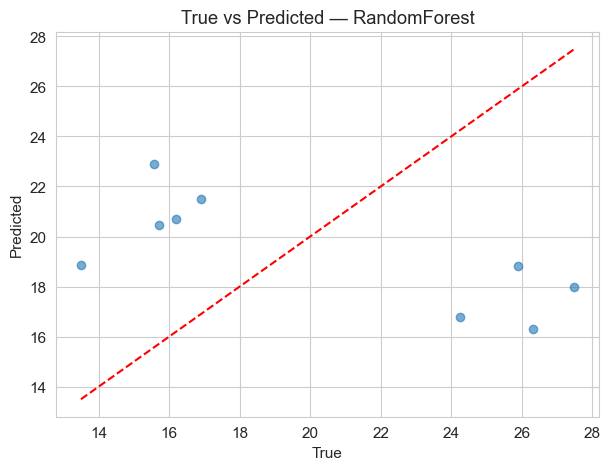

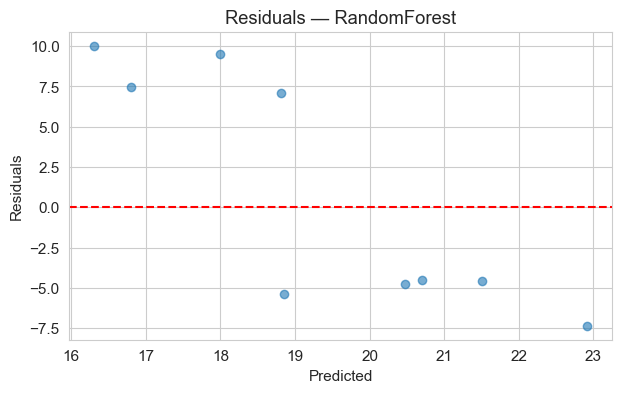

### Evaluating GradientBoosting

**GradientBoosting** — RMSE: 7.4206, MAE: 6.8950, R2: -0.9578

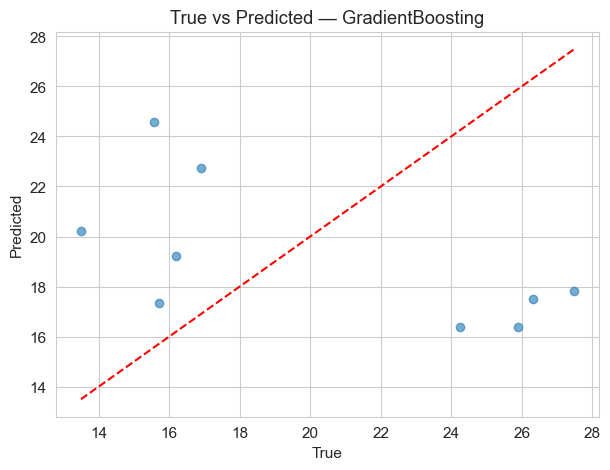

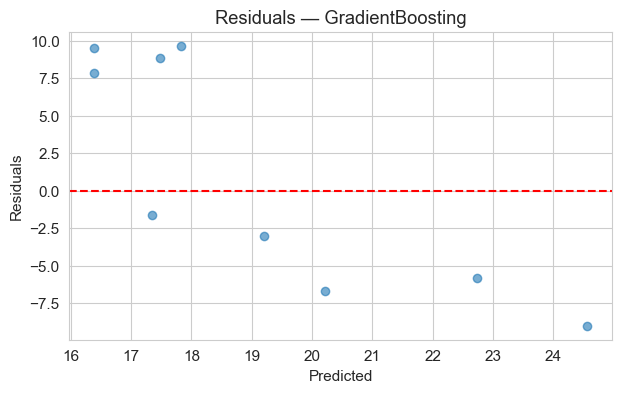

### Evaluating KNN

**KNN** — RMSE: 5.7400, MAE: 5.1080, R2: -0.1714

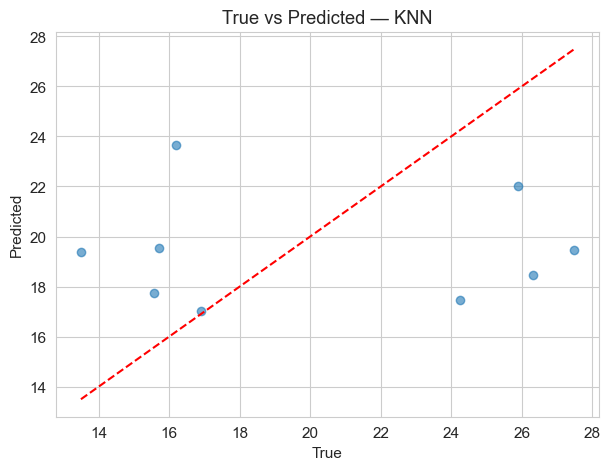

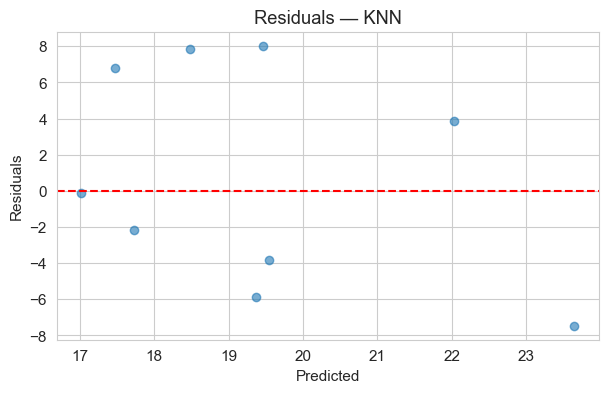

### Evaluation summary

,rmse,mae,r2
RandomForest,7.018506,6.737881,-0.751385
GradientBoosting,7.420615,6.895011,-0.957817
KNN,5.740018,5.108013,-0.171436


In [ ]:
# Final evaluation on test set
section("Final evaluation (test set)")
eval_results = {}
for name, model in best_models.items():
    display(Markdown(f"### Evaluating {name}"))
    try:
        y_pred = model.predict(X_test)
        if task_type == "regression":
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            eval_results[name] = {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}
            display(Markdown(f"**{name}** — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}"))
            # diagnostic plot: predicted vs actual
            fig = plt.figure(figsize=(7,5))
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.title(f"True vs Predicted — {name}")
            show_fig(fig); plt.close()
            # residuals plot
            fig = plt.figure(figsize=(7,4))
            plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
            plt.axhline(0, color="red", linestyle="--")
            plt.xlabel("Predicted")
            plt.ylabel("Residuals")
            plt.title(f"Residuals — {name}")
            show_fig(fig); plt.close()
        else:
            # classification metrics
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:,1] if model.predict_proba(X_test).shape[1] > 1 else model.predict_proba(X_test)[:,0]
            else:
                y_proba = None
            y_pred_label = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred_label)
            prec = precision_score(y_test, y_pred_label, average="weighted", zero_division=0)
            rec = recall_score(y_test, y_pred_label, average="weighted", zero_division=0)
            f1 = f1_score(y_test, y_pred_label, average="weighted", zero_division=0)
            eval_results[name] = {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)}
            display(Markdown(f"**{name}** — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}"))
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred_label)
            fig = plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Confusion Matrix — {name}")
            plt.ylabel("True")
            plt.xlabel("Pred")
            show_fig(fig); plt.close()
            display(Markdown("Classification report:"))
            display(pd.DataFrame(classification_report(y_test, y_pred_label, output_dict=True)).transpose())
            # ROC & PR curves (binary)
            if y_proba is not None and len(np.unique(y_test)) == 2:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = roc_auc_score(y_test, y_proba)
                fig = plt.figure(figsize=(6,5))
                plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
                plt.plot([0,1],[0,1], 'k--')
                plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC Curve — {name}")
                plt.legend()
                show_fig(fig); plt.close()
                # PR curve
                precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
                ap = average_precision_score(y_test, y_proba)
                fig = plt.figure(figsize=(6,5))
                plt.plot(recall_vals, precision, label=f"AP = {ap:.3f}")
                plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall — {name}")
                plt.legend()
                show_fig(fig); plt.close()
            # Calibration curve
            try:
                prob_pos = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") and model.predict_proba(X_test).shape[1] > 1 else (model.predict_proba(X_test)[:,0] if hasattr(model, "predict_proba") else None)
                if prob_pos is not None:
                    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
                    fig = plt.figure(figsize=(6,5))
                    plt.plot(mean_pred, frac_pos, "s-")
                    plt.plot([0,1],[0,1],"k--")
                    plt.xlabel("Mean predicted value"); plt.ylabel("Fraction of positives")
                    plt.title(f"Calibration curve — {name}")
                    show_fig(fig); plt.close()
            except Exception:
                pass
    except Exception as e:
        display(Markdown(f"Evaluation failed for {name}: {e}"))
        eval_results[name] = {"error": str(e)}

subsection("Evaluation summary")
display(pd.DataFrame(eval_results).T)

## Feature importance & explainability

### Explainability: RandomForest

Avg_Temp (°C)                                       0.124997
Precipitation (mm)                                  0.109899
Year                                                0.096193
_int_Urbanization_Index__Avg_Temp (°C)              0.069643
Vegetation_Index                                    0.067748
Month                                               0.064717
ENSO_Index                                          0.052404
Humidity (%)                                        0.049981
Urbanization_Index                                  0.049584
Solar_Irradiance (W/m²)                             0.047204
_int_CO2_Concentration (ppm)__Avg_Temp (°C)         0.046246
Max_Temp (°C)                                       0.036482
Min_Temp (°C)                                       0.036284
Cloud_Cover (%)                                     0.035147
CO2_Concentration (ppm)                             0.032032
Particulate_Matter (µg/m³)                          0.031831
Wind_Speed (m/s)        

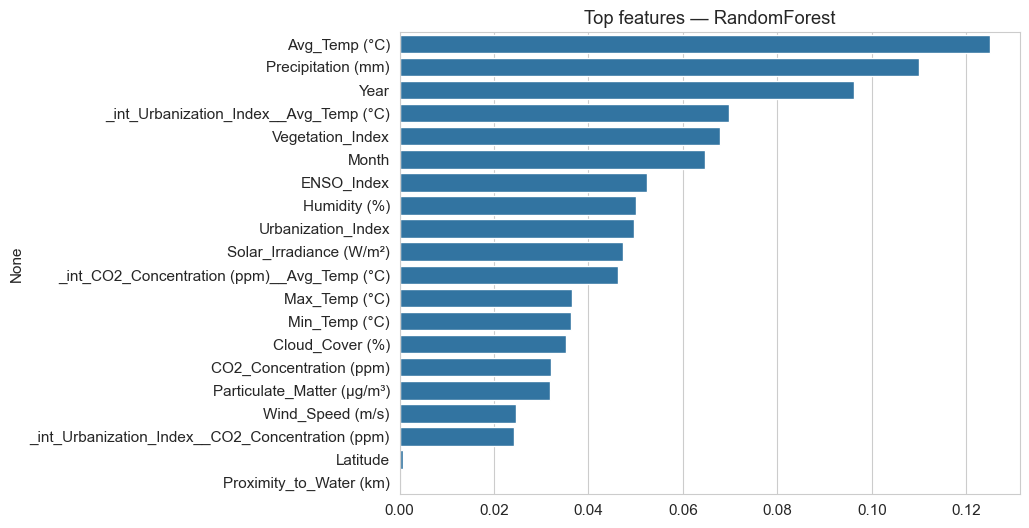

### Explainability: GradientBoosting

Avg_Temp (°C)                                       0.275221
Precipitation (mm)                                  0.239753
Month                                               0.167148
Cloud_Cover (%)                                     0.086684
_int_Urbanization_Index__Avg_Temp (°C)              0.071991
Vegetation_Index                                    0.036206
_int_Urbanization_Index__CO2_Concentration (ppm)    0.025570
_int_CO2_Concentration (ppm)__Avg_Temp (°C)         0.020035
Urbanization_Index                                  0.018584
ENSO_Index                                          0.017929
Max_Temp (°C)                                       0.010755
CO2_Concentration (ppm)                             0.008879
Particulate_Matter (µg/m³)                          0.006461
Humidity (%)                                        0.004155
Year                                                0.003566
Min_Temp (°C)                                       0.002558
Wind_Speed (m/s)        

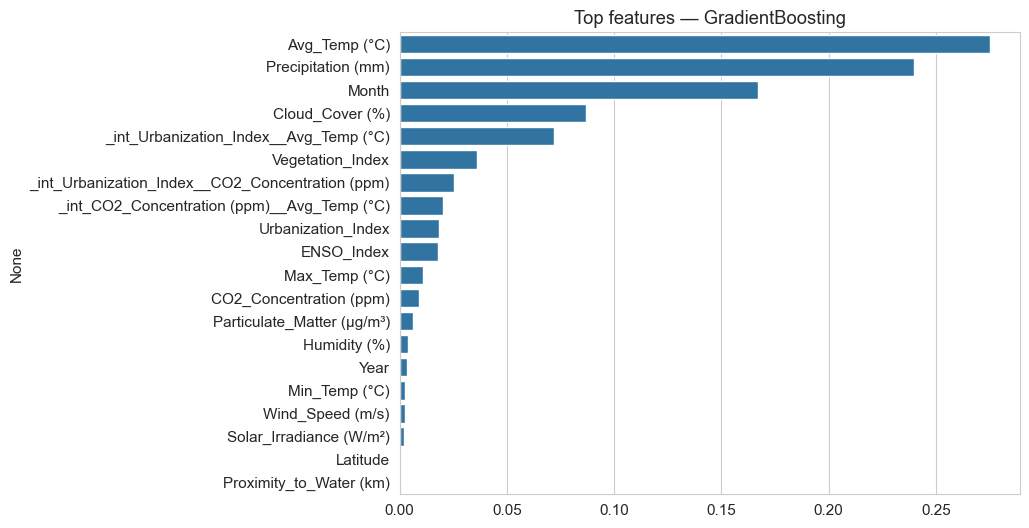

### Explainability: KNN

No standard feature importance/coefficients available for this model.

### Partial Dependence for RandomForest on ['Year', 'Month']

Computing PDP (may be slow) ...

In [ ]:
# Feature importance and explainability
section("Feature importance & explainability")
# Attempt to extract feature names after preprocessor
try:
    preprocessor.fit(X_train)
    numeric_names = numerical_features
    cat_names = []
    if categorical_features:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        try:
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        except Exception:
            for c in categorical_features:
                cats = list(X_train[c].dropna().unique())[:10]
                cat_names.extend([f"{c}__{v}" for v in cats])
    feature_names = numeric_names + cat_names
except Exception:
    feature_names = None

for name, model in best_models.items():
    display(Markdown(f"### Explainability: {name}"))
    try:
        estimator = model.named_steps.get("model", None)
        if estimator is None:
            display(Markdown("No 'model' step found in pipeline."))
            continue
        # Tree-based importances
        if hasattr(estimator, "feature_importances_") and feature_names is not None and len(feature_names) == len(estimator.feature_importances_):
            fi = estimator.feature_importances_
            fi_series = pd.Series(fi, index=feature_names).sort_values(ascending=False).head(20)
            display(fi_series)
            fig = plt.figure(figsize=(8,6))
            sns.barplot(x=fi_series.values, y=fi_series.index)
            plt.title(f"Top features — {name}")
            show_fig(fig); plt.close()
        # Coefficients for linear models
        elif hasattr(estimator, "coef_") and feature_names is not None:
            coef = estimator.coef_
            # handle multiclass
            if coef.ndim == 1:
                coef_series = pd.Series(coef, index=feature_names).sort_values(key=abs, ascending=False).head(20)
                display(coef_series)
            else:
                for i in range(coef.shape[0]):
                    coef_series = pd.Series(coef[i], index=feature_names).sort_values(key=abs, ascending=False).head(20)
                    display(Markdown(f"Class {i} top coeffs"))
                    display(coef_series)
        else:
            display(Markdown("No standard feature importance/coefficients available for this model."))
    except Exception as e:
        display(Markdown(f"Explainability extraction failed: {e}"))

# SHAP explanation if available (single-model, sample)
if SHAP_INSTALLED and feature_names is not None and len(best_models) > 0:
    # pick first tree-based or best model
    chosen = None
    for n,m in best_models.items():
        est = m.named_steps.get("model", None)
        if est is not None and (hasattr(est, "feature_importances_") or hasattr(est, "predict_proba")):
            chosen = (n,m); break
    if chosen:
        n,m = chosen
        subsection(f"SHAP explanation for {n} (sampled test rows)")
        try:
            # transform sample of X_test
            X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
            X_sample_trans = m.named_steps['preprocessor'].transform(X_sample)
            # shap expects a model object; for sklearn trees, TreeExplainer works best
            explainer = shap.Explainer(m.named_steps['model'])
            shap_values = explainer(X_sample_trans)
            display(Markdown("SHAP summary (beeswarm):"))
            shap.plots.beeswarm(shap_values, show=False)
            plt.title(f"SHAP beeswarm: {n}")
            show_fig(plt.gcf()); plt.close()
            display(Markdown("SHAP bar (mean abs):"))
            shap.plots.bar(shap_values, show=False)
            show_fig(plt.gcf()); plt.close()
        except Exception as e:
            display(Markdown(f"SHAP failed: {e}"))
    else:
        display(Markdown("No suitable model for SHAP found."))

# Partial Dependence Plots (PDP) for top 2 features of selected model
try:
    if feature_names is not None and len(best_models) > 0:
        model_name = list(best_models.keys())[0]
        model_pipe = best_models[model_name]
        est = model_pipe.named_steps['model']
        if feature_names and len(feature_names) >= 2:
            top_two = feature_names[:2]
            subsection(f"Partial Dependence for {model_name} on {top_two}")
            display(Markdown("Computing PDP (may be slow) ..."))
            fig, ax = plt.subplots(figsize=(10,5))
            display(PartialDependenceDisplay.from_estimator(model_pipe, X_test, features=[0,1] if hasattr(model_pipe, 'predict') else top_two, feature_names=feature_names, ax=ax))
            plt.close()
except Exception:
    pass

In [ ]:
# Time-series modelling (if time column & regression)
if TIME_COLUMN and TIME_COLUMN in df.columns and task_type == "regression":
    section("Time-series analysis & forecasting")
    try:
        ts_df = df[[TIME_COLUMN, TARGET_COLUMN]].dropna().sort_values(TIME_COLUMN).set_index(TIME_COLUMN)
        display(Markdown(f"Time series length: {len(ts_df)}"))
        # Plot series
        fig = plt.figure(figsize=(12,4))
        ts_df[TARGET_COLUMN].plot(title=f"Time series: {TARGET_COLUMN}")
        show_fig(fig); plt.close()
        # ADF test for stationarity
        if STATSMODELS_INSTALLED:
            adf_result = adfuller(ts_df[TARGET_COLUMN].dropna())
            display(Markdown(f"ADF statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}"))
        # Seasonal decomposition
        try:
            decomposition = sm.tsa.seasonal_decompose(ts_df[TARGET_COLUMN].interpolate(), period=12, model='additive', two_sided=False)
            fig = decomposition.plot()
            show_fig(fig); plt.close()
        except Exception:
            pass
        # Forecasting: try pmdarima auto_arima if available else Prophet if available
        train_len = int(len(ts_df) * 0.8)
        ts_train = ts_df.iloc[:train_len]
        ts_test = ts_df.iloc[train_len:]
        if PMDARIMA_INSTALLED:
            try:
                display(Markdown("Fitting pmdarima.auto_arima (may take time)..."))
                arima_model = pm.auto_arima(ts_train[TARGET_COLUMN].interpolate(), seasonal=True, m=12, suppress_warnings=True, stepwise=True, error_action="ignore")
                n_periods = len(ts_test)
                fc, conf = arima_model.predict(n_periods=n_periods, return_conf_int=True)
                fc_index = ts_test.index
                fig = plt.figure(figsize=(12,5))
                plt.plot(ts_train.index, ts_train[TARGET_COLUMN], label="Train")
                plt.plot(ts_test.index, ts_test[TARGET_COLUMN], label="Test")
                plt.plot(fc_index, fc, label="Forecast")
                plt.fill_between(fc_index, conf[:,0], conf[:,1], alpha=0.2)
                plt.legend()
                plt.title("ARIMA Forecast")
                show_fig(fig); plt.close()
                arima_rmse = mean_squared_error(ts_test[TARGET_COLUMN], fc, squared=False)
                display(Markdown(f"ARIMA RMSE on test portion: {arima_rmse:.4f}"))
            except Exception as e:
                display(Markdown(f"pmdarima forecasting failed: {e}"))
        elif PROPHET_INSTALLED:
            try:
                display(Markdown("Fitting Prophet model..."))
                prophet_df = ts_train.reset_index().rename(columns={TIME_COLUMN: "ds", TARGET_COLUMN: "y"})
                m = Prophet()
                m.fit(prophet_df)
                future = m.make_future_dataframe(periods=len(ts_test), freq='D' if ts_train.index.inferred_freq is None else ts_train.index.inferred_freq)
                forecast = m.predict(future)
                # plot
                fig = m.plot(forecast)
                show_fig(fig); plt.close()
            except Exception as e:
                display(Markdown(f"Prophet forecasting failed: {e}"))
        else:
            display(Markdown("No pmdarima or Prophet installed — skipping advanced forecasting. Consider installing 'pmdarima' or 'prophet'."))
    except Exception as e:
        display(Markdown(f"Time series branch failed: {e}"))

In [ ]:
# Statistical tests & hypothesis checks
section("Statistical tests & diagnostics (optional)")
try:
    if len(numeric_cols) >= 2 and STATSMODELS_INSTALLED:
        display(Markdown("Top pairwise Pearson correlations (p-values) for top numeric features:"))
        top_nums = numeric_cols[:6]
        corr_table = []
        for i,a in enumerate(top_nums):
            for b in top_nums[i+1:]:
                try:
                    r = df[a].corr(df[b])
                    # approximate p-value via statsmodels if desired; fallback to r only
                    corr_table.append({"feature_a": a, "feature_b": b, "r": r})
                except Exception:
                    pass
        if corr_table:
            display(pd.DataFrame(corr_table).sort_values("r", ascending=False).head(10))
except Exception:
    pass

## Statistical tests & diagnostics (optional)

Top pairwise Pearson correlations (p-values) for top numeric features:

,feature_a,feature_b,r
0,Avg_Temp (°C),CO2_Concentration (ppm),0.084935
2,CO2_Concentration (ppm),Urbanization_Index,0.084001
1,Avg_Temp (°C),Urbanization_Index,-0.162432
